# PFHub BM 1a in FiPy with Steppyngstounes

This notebook implements [PFHub] Benchmark [1a][spinodal] using [FiPy] and [steppyngstounes].
It also explores alternative initial conditions that are more-periodic than the specification.

<!-- links -->
[FiPy]: https://www.ctcms.nist.gov/fipy
[spinodal]: https://pages.nist.gov/pfhub/benchmarks/benchmark1.ipynb/#(a)-Square-periodic
[steppyngstounes]: https://github.com/usnistgov/steppyngstounes
[PFHub]: https://pages.nist.gov/pfhub/

In [1]:
%matplotlib inline

import time
startTime = time.time()

import gc
import matplotlib.pyplot as plt
import os
import pandas
import psutil

from fipy import FaceVariable, CellVariable
from fipy import DiffusionTerm, ImplicitSourceTerm, TransientTerm
from fipy import numerix, parallel, Viewer

from fipy import PeriodicGrid2D as Grid2D

from fipy.solvers.petsc import LinearLUSolver as Solver
from fipy.solvers.petsc.comms import petscCommWrapper

from petsc4py import PETSc

from steppyngstounes import CheckpointStepper, PIDStepper

cos  = numerix.cos
pi   = numerix.pi
ceil = numerix.ceil
log10 = numerix.log10

In [2]:
proc = psutil.Process()
comm = petscCommWrapper.PETScCommWrapper()
rank = parallel.procID

def mprint(*args, **kwargs):
    if rank == 0:
        print(*args, **kwargs)

## Prepare mesh & phase field

In [3]:
Lx = Ly = 200
dx = dy = 1.0
nx = int(Lx / dx)
ny = int(Ly / dy)

mesh = Grid2D(nx=nx, ny=ny, dx=dx, dy=dy)
x, y = mesh.cellCenters

c = CellVariable(mesh=mesh, name=r"$c$",   hasOld=True)
μ = CellVariable(mesh=mesh, name=r"$\mu$", hasOld=True)

### Set thermo-kinetic constants from the BM1 specification

In [4]:
α = 0.3
β = 0.7
ρ = 5
κ = 2
M = 5
c0 = 0.5
ϵ = 0.01

t = 0.0
dt = 1e-5
fin = 1_500_000
fin10 = log10(fin)

# Write to disk uniformly in logarithmic time
chkpts = [
    int(float(10**q)) for q in
    numerix.arange(0, fin10, 0.005)
]
if chkpts[-1] < fin:
    chkpts.append(fin)
chkpts = numerix.unique(chkpts)

## Define equations of motion

This is based on [fipy.examples.cahnHilliard.mesh2DCoupled],
using a first-order Taylor series substitution in place of the bulk free energy "source term".
The coupled equations are

$$
\frac{\partial c}{\partial t} = \nabla \cdot M\nabla\mu
$$

$$
\mu = \left(\frac{\partial f_{\mathrm{bulk}}}{\partial c} - \frac{\partial^2 f_{\mathrm{bulk}}}{\partial c^2} \cdot c\right)_{\mathrm{old}} + \frac{\partial^2 f_{\mathrm{bulk}}}{\partial c^2}\cdot c - \kappa \nabla^2 c
$$

where the second term on $\mu$ is an `ImplicitSourceTerm` and the last is a `DiffusionTerm`.

[fipy.examples.cahnHilliard.mesh2DCoupled]: https://www.ctcms.nist.gov/fipy/examples/cahnHilliard/generated/examples.cahnHilliard.mesh2DCoupled.html

In [5]:
# ## Uncomment and run this cell to double-check the derivatives.

# import sympy.abc
# from sympy import Eq, diff, expand, factor, symbols
# fbulk = sympy.abc.rho * (sympy.abc.c - sympy.abc.alpha)**2 \
#                       * (sympy.abc.beta - sympy.abc.c)**2

# display(Eq(symbols("f"), fchem))
# display(Eq(symbols("f'"), factor(diff(fchem,
#                                       sympy.abc.c))))
# display(Eq(symbols("f''"), factor(expand(diff(fbulk,
#                                              sympy.abc.c,
#                                              sympy.abc.c)))))

The free energy density and its first two derivatives are (refactored after SymPy)

$$f_{\mathrm{bulk}} = \rho (c - \alpha)^2 (\beta - c)^2$$

$$f'_{\mathrm{bulk}} = 2\rho (c - \alpha)(\beta - c)(\alpha - 2c + \beta)$$

$$f''_{\mathrm{bulk}} = 2\rho\left\{\alpha^2 + 4 \alpha \beta + \beta^2 - 6 c \left(\alpha - c + \beta\right)\right\}$$

In [6]:
fbulk = ρ * (c - α)**2 * (β - c)**2
d1fdc = 2 * ρ * (c - α) * (β - c) * (α - 2 * c + β)
d2fdc = 2 * ρ * (α**2 + 4*α*β + β**2 - 6 * c * (α - c + β))

In [7]:
eom_c = TransientTerm(var=c) == DiffusionTerm(coeff=M, var=μ)

eom_μ = ImplicitSourceTerm(coeff=1.0, var=μ) \
     == (d1fdc - d2fdc * c) \
      + ImplicitSourceTerm(coeff=d2fdc, var=c) \
      - DiffusionTerm(coeff=κ, var=c)

eom = eom_c & eom_μ

## Initial Conditions

In [8]:
# Choose your variant: "orig", "peri", or "zany"

variant = "peri"

if variant == "orig":
    # BM 1a specification v1.0: not periodic at all
    A0 = numerix.array([0.105, 0.130, 0.025, 0.070])
    B0 = numerix.array([0.110, 0.087,-0.150,-0.020])
elif variant == "peri":
    # Even integers as close to spec as achievable:
    # exactly periodic at the domain boundaries
    A0 = pi/Lx * numerix.array([6.0, 8.0, 2.0, 4.0])
    B0 = pi/Ly * numerix.array([8.0, 6.0,-10.,-2.0])
elif variant == "zany":
    # Perturbation of the periodic coefficients:
    # almost periodic, visually similar to the original
    A0 = pi/Lx * numerix.array([6.125, 7.875, 2.125, 4.125])
    B0 = pi/Ly * numerix.array([7.875, 5.125,-9.875,-1.875])
else:
    raise ValueError("Variant {} undefined.".format(variant))

iodir = variant
if not os.path.exists(iodir):
      os.mkdir(iodir)

In [9]:
def initialize(A, B):
    return c0 + ϵ * (
           cos(A[0] * x) * cos(B[0] * y) \
        + (cos(A[1] * x) * cos(B[1] * y))**2 \
        +  cos(A[2] * x  +     B[2] * y) \
        *  cos(A[3] * x  +     B[3] * y)
    )

c.value = initialize(A0, B0)
μ.value = d1fdc[:]

c.updateOld()
μ.updateOld()

## Prepare free energy output

In [10]:
df = None

labs = [
    "wall_time", 
    "time",     
    "free_energy",
    "mem_GB",    
    "timestep", 
    "mass"
]

if rank == 0:  # write the CSV header
    fcsv = "{}/energy.csv".format(iodir)
    with open(fcsv, "w") as fh:
        fh.write("{},{},{},{},{},{}\n".format(*labs))
else:
    fcsv = None

def update_energy(fh=None):
    # Integration of fields: CellVolumeAverage, .sum(), 
    nrg = (fbulk - 0.5 * κ * numerix.dot(c.grad, c.grad)).sum()
    mas = c.sum()
    mem = comm.allgather(proc.memory_info().rss) / 1024**3
    if rank == 0:
        timer = time.time() - startTime
    
        vals = [timer, t, nrg, mem, dt, mas]
        
        with open(fcsv, "a") as fh:
            fh.write("{},{},{},{},{},{}\n".format(*vals))
        
update_energy(fcsv)

## Timestepping

In [ ]:
rtol = 1e-3
solver = Solver()

# mprint("Writing a checkpoint at the following times:")
# mprint(chkpts)

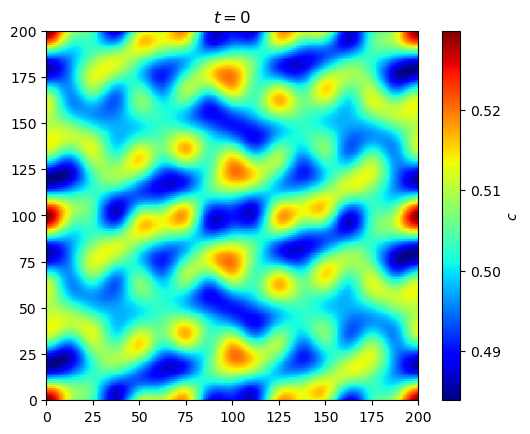

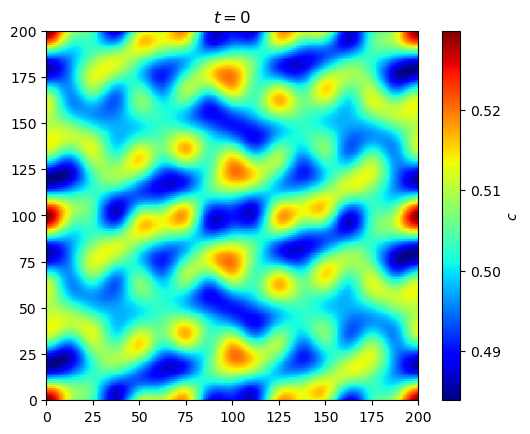

In [12]:
viewer = Viewer(vars=(c,), 
                title="$t = 0$",
                datamin=c.min(), datamax=c.max())

def write_plot():
    imgname = "%s/spinodal.%08d.png" % (iodir, int(t))
    if rank == 0 and not os.path.exists(imgname):
        viewer.title = r"$t = %12g$" % t
        viewer.datamin = float(c.min())
        viewer.datamax = float(c.max())
        viewer.plot(filename=imgname)


write_plot()

In [13]:
def stepper(check):
    global dt
    global t

    for step in PIDStepper(start=check.begin,
                           stop=check.end,
                           size=dt):
        mprint("    Stepping [{:12g} .. {:12g}) / {:12g}".format(
            float(step.begin), float(step.end), float(step.size)),
               end=" ")
        
        for sweep in range(2):
            res = eom.sweep(dt=step.size, solver=solver)      

        if step.succeeded(error=res/rtol):
            mprint("✔")
            dt = step.size
            t += dt
            c.updateOld()
            μ.updateOld()
            update_energy(fcsv)
        else:
            mprint("✘")
            c.value = c.old
            μ.value = μ.old

        PETSc.garbage_cleanup()

    dt = step.want
    
    write_plot()
    viewer.plot()

In [14]:
def checkers():
    global dt
    global t
    for check in CheckpointStepper(start=0.0,
                                   stops=chkpts,
                                   stop=fin):
        mprint("Launching [{:12g} .. {:12g})".format(
            check.begin, check.end))

        stepper(check)

        _ = check.succeeded()

        gc.collect()

In [ ]:
checkers()
plt.close()

Launching [           0 ..            1)
    Stepping [           0 ..        1e-05) /        1e-05 ✔
    Stepping [       1e-05 ..  6.42517e-05) /  5.42517e-05 ✔
    Stepping [ 6.42517e-05 ..  0.000166472) /   0.00010222 ✔
    Stepping [ 0.000166472 ..  0.000371183) /  0.000204711 ✔
    Stepping [ 0.000371183 ..  0.000728556) /  0.000357373 ✔
    Stepping [ 0.000728556 ..   0.00130147) /  0.000572909 ✔
    Stepping [  0.00130147 ..   0.00215207) /  0.000850601 ✔
    Stepping [  0.00215207 ..   0.00333725) /   0.00118518 ✔
    Stepping [  0.00333725 ..   0.00490267) /   0.00156543 ✔
    Stepping [  0.00490267 ..   0.00687971) /   0.00197704 ✔
    Stepping [  0.00687971 ..   0.00928439) /   0.00240468 ✔
    Stepping [  0.00928439 ..    0.0121183) /   0.00283391 ✔
    Stepping [   0.0121183 ..    0.0153707) /    0.0032524 ✔
    Stepping [   0.0153707 ..    0.0190212) /   0.00365056 ✔
    Stepping [   0.0190212 ..    0.0230429) /   0.00402163 ✔
    Stepping [   0.0230429 ..    0.0274044) 

    Stepping [    0.674449 ..     0.680236) /   0.00578672 ✔
    Stepping [    0.680236 ..     0.686053) /   0.00581742 ✔
    Stepping [    0.686053 ..     0.691896) /    0.0058424 ✔
    Stepping [    0.691896 ..     0.697758) /   0.00586252 ✔
    Stepping [    0.697758 ..     0.703637) /   0.00587854 ✔
    Stepping [    0.703637 ..     0.709528) /   0.00589108 ✔
    Stepping [    0.709528 ..     0.715428) /    0.0059007 ✔
    Stepping [    0.715428 ..     0.721336) /   0.00590784 ✔
    Stepping [    0.721336 ..     0.727249) /   0.00591291 ✔
    Stepping [    0.727249 ..     0.733165) /   0.00591622 ✔
    Stepping [    0.733165 ..     0.739083) /   0.00591807 ✔
    Stepping [    0.739083 ..     0.745002) /   0.00591867 ✔
    Stepping [    0.745002 ..      0.75092) /   0.00591824 ✘
    Stepping [    0.745002 ..     0.749737) /   0.00473459 ✔
    Stepping [    0.749737 ..      0.75375) /     0.004013 ✔
    Stepping [     0.75375 ..     0.758095) /   0.00434483 ✔
    Stepping [    0.7580

In [ ]:
df = pandas.read_csv("{}/energy.csv".format(iodir))

In [ ]:
plt.figure(1)
plt.xlabel(r"time $t$ / [a.u.]")
plt.ylabel(r"Free energy $\mathcal{F}$ / [J/m³]")
plt.semilogy(df.time, df.free_energy)
plt.savefig("{}/energy.png".format(iodir), bbox_inches="tight")
plt.close()

In [ ]:
plt.figure(2)
plt.xlabel(r"time $t$ / [a.u.]")
plt.ylabel("Memory / [GB]")
plt.semilogy(df.time, df.mem_GB)
plt.savefig("{}/memory.png".format(iodir), bbox_inches="tight")
plt.close()